In [283]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LassoCV

In [284]:
df = pd.read_csv('data/cleaned_grit_data.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (2200, 101)


,index,country,surveyelapse,GS1,GS2,GS3,GS4,GS5,GS6,GS7,...,browser,introelapse,testelapse,Extraversion,Neuroticism,Agreeableness,Conscientiousness,Openness,Grit,highgrit
0,4,JP,340,5,2,3,3,2,4,2,...,Firefox,3,337,1.2,2.5,3.3,3.8,3.0,3.083333,0
1,6,US,126,4,1,3,2,1,5,1,...,Chrome,36,212,4.0,2.0,3.6,3.4,5.0,2.583333,0
2,8,EU,130,5,3,3,5,4,5,5,...,Microsoft Internet Explorer,14,183,4.4,4.5,4.7,4.0,4.3,4.250000,1
3,10,AE,592,5,3,3,2,4,3,3,...,Chrome,726,311,3.0,4.6,3.6,3.8,3.4,3.166667,0
4,11,AU,217,3,1,1,2,1,3,1,...,Firefox,376,407,2.0,1.1,3.4,3.9,4.4,2.000000,0


#### Binning the Age Column

- Created three age categories:
  - 18-30
  - 30-45
  - 45+
- Stored these in a new column called age_group.
- The original age column has been left untouched for potential future use.

In [285]:
bins = [0, 30, 45, float('inf')] 
labels = ['18-30', '30-45', '45+']

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

df[['age', 'age_group']].head()

,age,age_group
0,38,30-45
1,35,30-45
2,50,45+
3,52,45+
4,20,18-30


#### Survey Time and Vocabulary Scores

- **Survey Time Score**:  
  - Combined time spent on different sections of the survey to create a composite column called survey_time_score
  - Included columns:
    - introelapse
    - testelapse
    - surveyelapse  

- **Vocabulary Score**:  
  - Created a vacabulary score based on the check-list of words (VCL1–VCL15) and stored it in a cloumn called "vocab_score"
  - Allcolumns wew included except for the previously removed validation columns (VCL6, VCL9, and VCL12)
  - Each checked real word contributes 1 point.  

In [286]:
df['survey_time_score'] = df['introelapse'] + df['testelapse'] + df['surveyelapse']

vcl_cols = ['VCL1','VCL2','VCL3','VCL4','VCL5',
            'VCL7','VCL8','VCL10','VCL11','VCL13','VCL14','VCL15']

df['vocab_score'] = df[vcl_cols].sum(axis=1)


#### Encoding Categorical Variables

- Replaced nulls in the education column with the mode, to ensure ordinal encoding works correctly without "Unknown" values.
- Mapped education categories to numbers:
  - "Less than high school" → 0
  - "High school" → 1
  - "University" → 2
  - "Graduate" → 3
- Replaced all other null values with "Unknown".
- One-hot encoded all other categorical columns, excluding country.
- The country column has been left untouched for potential future use.

In [287]:
null_columns = df.isna().sum()
print(null_columns[null_columns > 0])

education      19
urban          25
gender          3
engnat         11
hand            7
religion       28
orientation    55
race           17
voted          16
married         8
dtype: int64


In [288]:
mode_value = df['education'].mode()[0]
df['education'] = df['education'].fillna(mode_value)

education_mapping = {
    "Less than high school": 0,
    "High school": 1,
    "University": 2,
    "Graduate": 3
}
df['education'] = df['education'].map(education_mapping)

df["education"]

0       3
1       2
2       2
3       2
4       1
       ..
2195    3
2196    1
2197    1
2198    2
2199    1
Name: education, Length: 2200, dtype: int64

In [289]:
cols_to_fill = [
    'urban', 'gender', 'engnat', 'hand',
    'religion', 'orientation', 'race',
    'voted', 'married'
]

df[cols_to_fill] = df[cols_to_fill].fillna("Unknown")

cols_to_encode = ['urban', 'gender', 'engnat', 'hand',
    'religion', 'orientation', 'race',
    'voted', 'married', "browser", "operatingsystem", "age_group"]
print(cols_to_encode)
df = pd.get_dummies(df, columns=cols_to_encode, dummy_na=False)
dummy_cols = [col for col in df.columns if any(orig in col for orig in cols_to_encode)]
df[dummy_cols] = df[dummy_cols].astype(int)

print(df.shape)
df.head()

['urban', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'race', 'voted', 'married', 'browser', 'operatingsystem', 'age_group']
(2200, 160)


,index,country,surveyelapse,GS1,GS2,GS3,GS4,GS5,GS6,GS7,...,operatingsystem_ChromeOS,operatingsystem_Linux,operatingsystem_Macintosh,operatingsystem_Unknown,operatingsystem_Windows,operatingsystem_Windows Phone,operatingsystem_iOS,age_group_18-30,age_group_30-45,age_group_45+
0,4,JP,340,5,2,3,3,2,4,2,...,0,0,0,0,1,0,0,0,1,0
1,6,US,126,4,1,3,2,1,5,1,...,0,0,0,0,1,0,0,0,1,0
2,8,EU,130,5,3,3,5,4,5,5,...,0,0,0,0,1,0,0,0,0,1
3,10,AE,592,5,3,3,2,4,3,3,...,0,0,0,0,1,0,0,0,0,1
4,11,AU,217,3,1,1,2,1,3,1,...,0,0,0,0,1,0,0,1,0,0


#### Scaling the Data

I'm unsure if we want to scale our data or if we do then when we want to scale or which columns specificalyy we want to scale so I created a new data frame df_scaled with all features scaled.
- I personally believe that all timing data needs to be scaled at the very least (Fida)

In [290]:
num_cols = df.drop(columns='country').columns

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[num_cols])

df_scaled = pd.DataFrame(df_scaled, columns=num_cols, index=df.index)

df_scaled.head()

,index,surveyelapse,GS1,GS2,GS3,GS4,GS5,GS6,GS7,GS8,...,operatingsystem_ChromeOS,operatingsystem_Linux,operatingsystem_Macintosh,operatingsystem_Unknown,operatingsystem_Windows,operatingsystem_Windows Phone,operatingsystem_iOS,age_group_18-30,age_group_30-45,age_group_45+
0,-1.712706,0.694531,1.127373,-0.448839,0.037770,-0.167678,-0.652937,-0.094981,-0.889894,0.763276,...,-0.102786,-0.321419,-0.422328,-0.077099,0.770846,-0.030165,-0.351562,-1.451670,1.994336,-0.370862
1,-1.711067,-0.738854,0.119563,-1.340036,0.037770,-1.027568,-1.440039,0.872415,-1.730498,-1.559280,...,-0.102786,-0.321419,-0.422328,-0.077099,0.770846,-0.030165,-0.351562,-1.451670,1.994336,-0.370862
2,-1.709428,-0.712061,1.127373,0.442358,0.037770,1.552101,0.921267,0.872415,1.631918,0.763276,...,-0.102786,-0.321419,-0.422328,-0.077099,0.770846,-0.030165,-0.351562,-1.451670,-0.501420,2.696419
3,-1.707789,2.382441,1.127373,0.442358,0.037770,-1.027568,0.921267,-1.062376,-0.049290,-0.010909,...,-0.102786,-0.321419,-0.422328,-0.077099,0.770846,-0.030165,-0.351562,-1.451670,-0.501420,2.696419
4,-1.706969,-0.129330,-0.888247,-1.340036,-1.607645,-1.027568,-1.440039,-1.062376,-1.730498,-0.785094,...,-0.102786,-0.321419,-0.422328,-0.077099,0.770846,-0.030165,-0.351562,0.688862,-0.501420,-0.370862


#### Personality Trait Interactions

In [291]:
df_engineered = df.copy()
traits = ['Openness', 'Conscientiousness', 
          'Extraversion', 'Agreeableness', 'Neuroticism']

In [292]:
# Create all pairwise interactions (10 total combinations)
interaction_features = []
for trait1, trait2 in combinations(traits, 2):
  feature_name = f'{trait1}_x_{trait2}'
  df_engineered[feature_name] = df_engineered[trait1] * df_engineered[trait2]
  interaction_features.append(feature_name)
  print(f"Created: {feature_name}")

print(f"\nTotal interaction features created: {len(interaction_features)}")

Created: Openness_x_Conscientiousness
Created: Openness_x_Extraversion
Created: Openness_x_Agreeableness
Created: Openness_x_Neuroticism
Created: Conscientiousness_x_Extraversion
Created: Conscientiousness_x_Agreeableness
Created: Conscientiousness_x_Neuroticism
Created: Extraversion_x_Agreeableness
Created: Extraversion_x_Neuroticism
Created: Agreeableness_x_Neuroticism

Total interaction features created: 10



Interaction Feature Correlations with Grit:
Conscientiousness_x_Agreeableness    0.615659
Conscientiousness_x_Neuroticism      0.599657
Openness_x_Conscientiousness         0.558125
Conscientiousness_x_Extraversion     0.524512
Agreeableness_x_Neuroticism          0.438798
Extraversion_x_Neuroticism           0.373226
Openness_x_Neuroticism               0.360135
Extraversion_x_Agreeableness         0.288706
Openness_x_Agreeableness             0.262775
Openness_x_Extraversion              0.214245
Name: Grit, dtype: float64


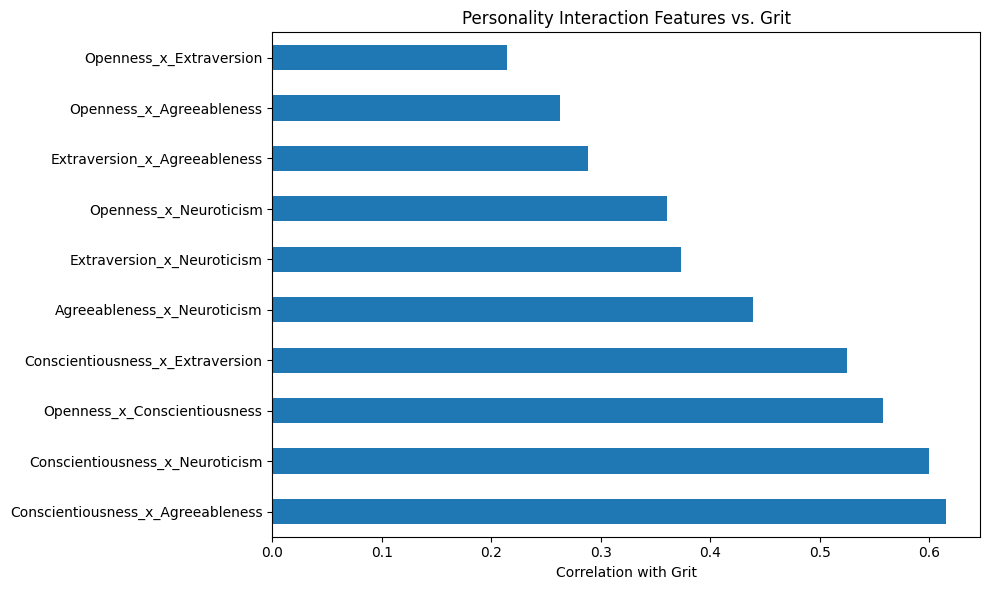

In [293]:
# Check correlations of interaction features with Grit + visualization
interaction_corr = df_engineered[interaction_features + ['Grit']].corr()['Grit'].drop('Grit').sort_values(ascending=False)
print("\nInteraction Feature Correlations with Grit:")
print(interaction_corr)

plt.figure(figsize=(10, 6))
interaction_corr.plot(kind='barh')
plt.xlabel('Correlation with Grit')
plt.title('Personality Interaction Features vs. Grit')
plt.tight_layout()
plt.show()

#### Demographic-Personality Interactions

In [294]:
# INCORRECT, GIVING ERROR
# Age × Conscientiousness
df_engineered['Age_x_Consc'] = df_engineered['age'] * df_engineered['Conscientiousness']

# Age × Openness
df_engineered['Age_x_Open'] = df_engineered['age'] * df_engineered['Openness']

# Education × Openness
df_engineered['Edu_x_Open'] = df_engineered['education'] * df_engineered['Openness']

# Education × Conscientiousness
df_engineered['Edu_x_Consc'] = df_engineered['education'] * df_engineered['Conscientiousness']

demographic_interactions = ['Age_x_Consc', 'Age_x_Open', 'Edu_x_Open', 'Edu_x_Consc']
print("Created demographic interaction features:")
for feat in demographic_interactions:
  print(f"  - {feat}")

Created demographic interaction features:
  - Age_x_Consc
  - Age_x_Open
  - Edu_x_Open
  - Edu_x_Consc


In [295]:
#code for saving the dataframe

#df_engineered.reset_index(inplace=True)
#df_engineered.to_csv('./data/cleaned_grit_data.csv', index=False)